Nonconjugate model for a bioassay experiment (BDA3 p.74)

In [2]:
import numpy as np
import pandas as pd
from scipy.special import expit  
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load data
df = pd.read_csv('../data/bioassay.csv')
x = df.dose.values
n = df.num_animals.values
y = df.num_deaths.values

### Maximum likelihood estimate of ($\alpha, \beta$)

In [4]:
# Atructure data in individual observation format for fitting logistic regression
# It is feasible to use glm in R for fitting a count table. However, it's not possible for LogisticRegression in sklearn
xx = np.repeat(x,n).reshape(-1,1)
yy = [[1]*y[i] + [0]*(n[i]-y[i]) for i in range(len(y))]
yy = np.asarray(yy).ravel()
lm = LogisticRegression(penalty='none', solver='lbfgs').fit(xx,yy)

# M.L.E point estimate
alpha_hat, beta_hat = np.asscalar(lm.intercept_), np.asscalar(lm.coef_)

# Design matrix - add column of 1's at the beginning of X matrix
X_design = np.hstack([np.ones((xx.shape[0], 1)), xx])
# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
p_hat = lm.predict_proba(xx)
V = np.diagflat(np.product(p_hat, axis=1))

# Covariance matrix
# Note that the @-operater does matrix multiplication in Python 3.5+, so if you're running
# Python 3.5+, you can replace the covLogit-line below with the more readable:
# cov_logit = np.linalg.inv(X_design.T @ V @ X_design)
cov_logit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
# print("Covariance matrix: ", cov_logit)

# Standard errors
alpha_se, beta_se = np.sqrt(np.diag(cov_logit))
# Wald statistic (coefficient / s.e.) ^ 2
alpha_w, beta_w = alpha_hat / alpha_se**2, beta_hat / beta_se**2

mle_df = pd.DataFrame({'point_estimate':[alpha_hat, beta_hat]
                       , 'standard_error':[alpha_se, beta_se]
                       , 'Wald_statistics': [alpha_w, beta_w]}
                     , index=['alpha','beta'])
print(mle_df)

       point_estimate  standard_error  Wald_statistics
alpha        0.846554        1.019077         0.815156
beta         7.748719        4.872704         0.326355


### Posterior distribution given the noninformative prior

In [10]:
# Compute the posterior density in grid
a_grid = np.linspace(-5, 10, 100)
b_grid = np.linspace(-10, 40, 100)
inv_logit_x = 1 / (np.exp(-(a_grid[:,np.newaxis] + np.outer(b_grid, x)[:, np.newaxis, :])) + 1)
likelihood = np.prod(inv_logit_x**y * (1 - inv_logit_x)**(n - y), axis=2)  # 100 by 100 
# Since the prior is uniform, the posterior is proportional to the likelihood
post_den = likelihood / np.sum(likelihood)

# draws from unnormalized posterior density
# seed a random state
rng = np.random.RandomState(123)

n_sample = 1000
sample_ind = np.unravel_index(rng.choice(post_den.size, size=n_sample, p=post_den.ravel()), post_den.shape)
sample_a = a_grid[sample_ind[1]]
sample_b = b_grid[sample_ind[0]]
# add random jitter
sample_a += (rng.rand(n_sample) - 0.5) * (a_grid[1]-a_grid[0])
sample_b += (rng.rand(n_sample) - 0.5) * (b_grid[1]-b_grid[0])

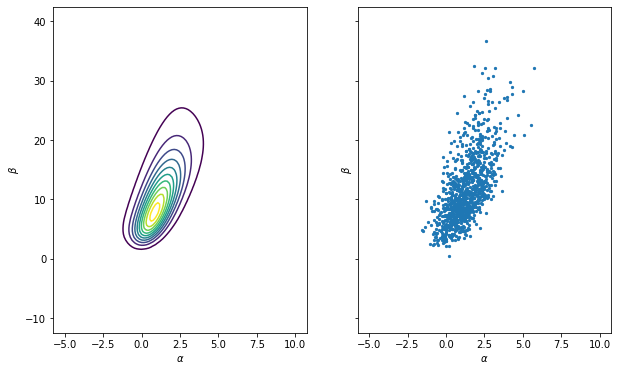

In [22]:
# plot the joint posterior density and random draws
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), sharex=True, sharey=True)
ax1.contour(a_grid, b_grid, post_den, levels = np.arange(0.05, 1, 0.1)*post_den.max())
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel(r'$\beta$');
ax2.scatter(sample_a, sample_b, 5)
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel(r'$\beta$');

### The posterior distribution of the LD50

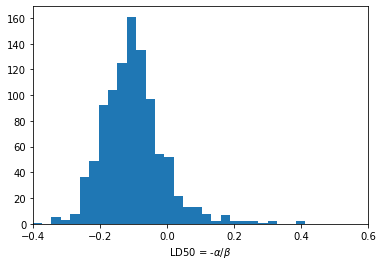

In [25]:
# samples of LD50 conditional beta > 0
b_pos_ind = sample_b > 0
sample_ld50 = -sample_a[b_pos_ind]/sample_b[b_pos_ind]

# plot the histogram of LD50
plt.hist(sample_ld50, bins=30)
plt.xlim([-0.4, 0.6])
plt.xlabel(r'LD50 = -$\alpha/\beta$');

### $\theta$ samples given the posterior draws

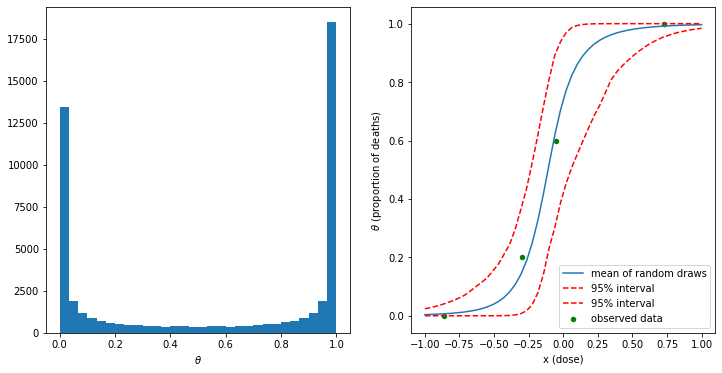

In [37]:
xt = np.linspace(-1, 1)
sample_theta = expit(sample_a[:, np.newaxis] + np.outer(sample_b, xt)) # the inverse of logit function, a.k.a, sigmoid function

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(np.ravel(sample_theta), bins=30)
ax1.set_xlabel(r'$\theta$');

# plot mean and [5% 95%] interval
ax2.plot(xt, np.mean(sample_theta, axis=0).T, label='mean of random draws')
ax2.plot(xt, np.percentile(sample_theta, [5, 95], axis=0).T, color ='red', linestyle='--', label='95% interval')
ax2.scatter(x, y/n, 20, color='green', label='observed data')
ax2.legend()
ax2.set_xlabel('x (dose)')
ax2.set_ylabel(r'$\theta$ (proportion of deaths)');